In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## 1. data

- visualization
- reshaping
- standardization

In [2]:
close_ = pd.read_csv('./data/close_000001.SZ.csv', index_col=0, squeeze=True, parse_dates=True)
adj_ = pd.read_csv('./data/adj_000001.SZ.csv', index_col=0, squeeze=True, parse_dates=True)

In [3]:
close_.head()

2017-01-03    9.16
2017-01-04    9.16
2017-01-05    9.17
2017-01-06    9.13
2017-01-09    9.15
Name: 000001.SZ, dtype: float64

In [4]:
adj_.head()

2017-01-03    104.7583
2017-01-04    104.7583
2017-01-05    104.7583
2017-01-06    104.7583
2017-01-09    104.7583
Name: 000001.SZ, dtype: float64

In [5]:
price = close_.mul(adj_).div(adj_.iloc[-1]).ffill()

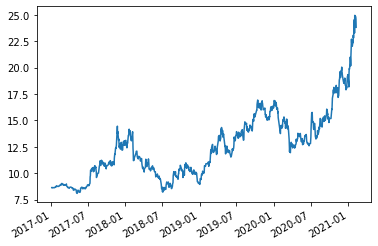

In [6]:
price.plot();

In [7]:
# global parameters
T = 20
lag = 5
split_date = '20200531'
end_date = '20210131'
use_cuda = True

device = 'cuda' if use_cuda and torch.cuda.is_available() else 'cpu' # use GPU if possible for it's folds faster

In [8]:
# training data
trn_data = price.loc[:split_date]

In [9]:
df = pd.concat([price.shift(T-i-1) for i in range(T)], axis=1, keys=[f't-{T-i-1}' for i in range(T)]) # X data
df[f't+{lag}'] = price.shift(-lag) # y targets
df = df.iloc[T-1:] # dump NaNs

In [10]:
df.head()

,t-19,t-18,t-17,t-16,t-15,t-14,t-13,t-12,t-11,t-10,...,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t-0,t+5
2017-02-06,8.641127,8.641127,8.650561,8.612827,8.631694,8.631694,8.622260,8.631694,8.641127,8.622260,...,8.650561,8.659994,8.697728,8.697728,8.744896,8.735463,8.801497,8.735463,8.782630,8.876966
2017-02-07,8.641127,8.650561,8.612827,8.631694,8.631694,8.622260,8.631694,8.641127,8.622260,8.631694,...,8.659994,8.697728,8.697728,8.744896,8.735463,8.801497,8.735463,8.782630,8.773197,8.867532
2017-02-08,8.650561,8.612827,8.631694,8.631694,8.622260,8.631694,8.641127,8.622260,8.631694,8.650561,...,8.697728,8.697728,8.744896,8.735463,8.801497,8.735463,8.782630,8.773197,8.773197,8.914700
2017-02-09,8.612827,8.631694,8.631694,8.622260,8.631694,8.641127,8.622260,8.631694,8.650561,8.659994,...,8.697728,8.744896,8.735463,8.801497,8.735463,8.782630,8.773197,8.773197,8.782630,8.924134
2017-02-10,8.631694,8.631694,8.622260,8.631694,8.641127,8.622260,8.631694,8.650561,8.659994,8.697728,...,8.744896,8.735463,8.801497,8.735463,8.782630,8.773197,8.773197,8.782630,8.801497,8.858099


In [11]:
price.iloc[:30].reset_index(name='price')

,index,price
0,2017-01-03,8.641127
1,2017-01-04,8.641127
2,2017-01-05,8.650561
3,2017-01-06,8.612827
4,2017-01-09,8.631694
5,2017-01-10,8.631694
6,2017-01-11,8.622260
7,2017-01-12,8.631694
8,2017-01-13,8.641127
9,2017-01-16,8.622260


In [12]:
## mapminmax --> [-1, 1] ~ tanh function
# (df - trn_data.min()) / (trn_data.max() - trn_data.min()) = (new_df + 1) / 2
new_df = 2 * (df - trn_data.min()) / (trn_data.max() - trn_data.min()) - 1

## zscore --> N(0, 1)
# new_df = (df - trn_data.mean()) / trn_data.std()

In [13]:
# train-validation indices
idx1 = len(new_df.loc[:split_date])
idx2 = len(new_df.loc[:end_date])

In [14]:
X_trn = new_df.iloc[:idx1, :T].values
X_val = new_df.iloc[idx1:idx2, :T].values
y_trn = new_df.iloc[:idx1, T].values
y_val = new_df.iloc[idx1:idx2, T].values

In [15]:
X_trn.shape, X_val.shape, y_trn.shape, y_val.shape

((809, 20), (166, 20), (809,), (166,))

## 2. model

- LSTM
- GRU

In [16]:
class LSTMREG(nn.Module):
    def __init__(self, input_size, hidden_size, n_layer, dropout, device, output_size=1):
        super(LSTMREG, self).__init__()
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size, hidden_size, n_layer, dropout=self.dropout)
        self.linear = nn.Linear(hidden_size, output_size)
        
        self.hidden_cell = (torch.randn(n_layer, 1, hidden_size).to(device),
                            torch.randn(n_layer, 1, hidden_size).to(device))
        
    def forward(self, x):
        o, self.hidden_cell = self.lstm(x.view(len(x), 1, -1), self.hidden_cell)
        o = F.dropout(o, p=self.dropout)
        o = self.linear(o.view(len(o), -1))
        
        return o.squeeze(-1)

In [23]:
## Rsquared
def rsquared_metric(y_pred, y_true):
    R_total = (y_true-torch.mean(y_true)).pow(2.0).sum()
    R_pred = (y_pred-y_true).pow(2.0).sum()
    Rsquared = 1 - R_pred / R_total
    
    return Rsquared

In [18]:
X_trn = torch.from_numpy(X_trn).float().to(device)
X_val = torch.from_numpy(X_val).float().to(device)
y_trn = torch.from_numpy(y_trn).float().to(device)
y_val = torch.from_numpy(y_val).float().to(device)

In [19]:
savename = 'stock_price_prediction_000001.SZ_lstm_regression'
checkpoint = './checkpoint/' + savename + '.pt'
result = './result/' + savename + '.csv'

In [20]:
# global parameters
hidden_size = 500
n_layer = 2
dropout = 0.5
lr = .001 # learning rate

In [21]:
model = LSTMREG(T, hidden_size, n_layer, dropout, device).to(device)
loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr) # Adam

In [24]:
## training
r = pd.DataFrame()

for epoch in range(1, 2001):
    model.train()
    y_trn_pred = model(X_trn)
    trn_loss = loss_func(y_trn_pred, y_trn)
    trn_score = rsquared_metric(y_trn_pred, y_trn)
    
    optimizer.zero_grad()
    trn_loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = loss_func(y_val_pred, y_val)
        val_score = rsquared_metric(y_val_pred, y_val)
        
    r_epoch = pd.Series(
        {'trn_loss': trn_loss.item(), 'trn_score': trn_score.item(), 'val_loss': val_loss.item(), 'val_score': val_score.item()},
        name=epoch
    )
    r = r.append(r_epoch)
    
    if (r.loc[epoch, 'val_score'] >= .6) and (r.loc[epoch, 'val_score'] > r.loc[:epoch-1, 'val_score'].max()):
        torch.save(model.state_dict(), checkpoint)
        
    if (epoch % 200 == 0):
        print(f'Epoch {epoch}')
        print(f'  trn_loss: {trn_loss.item():.4f}, trn_score: {trn_score.item():.4f}')
        print(f'  val_loss: {val_loss.item():.4f}, val_score: {val_score.item():.4f}')
        
r.to_csv(result)

Epoch 200
  trn_loss: 0.2703, trn_score: 0.0267
  val_loss: 1.4653, val_score: -2.2245
Epoch 400
  trn_loss: 0.2360, trn_score: 0.1502
  val_loss: 1.4517, val_score: -2.1944
Epoch 600
  trn_loss: 0.2090, trn_score: 0.2474
  val_loss: 1.3767, val_score: -2.0294
Epoch 800
  trn_loss: 0.1838, trn_score: 0.3383
  val_loss: 1.2742, val_score: -1.8040
Epoch 1000
  trn_loss: 0.1562, trn_score: 0.4375
  val_loss: 1.1257, val_score: -1.4771
Epoch 1200
  trn_loss: 0.1306, trn_score: 0.5298
  val_loss: 0.9697, val_score: -1.1338
Epoch 1400
  trn_loss: 0.1063, trn_score: 0.6171
  val_loss: 0.8330, val_score: -0.8331
Epoch 1600
  trn_loss: 0.0873, trn_score: 0.6859
  val_loss: 0.6830, val_score: -0.5031
Epoch 1800
  trn_loss: 0.0709, trn_score: 0.7446
  val_loss: 0.5628, val_score: -0.2384
Epoch 2000
  trn_loss: 0.0611, trn_score: 0.7799
  val_loss: 0.4579, val_score: -0.0077


In [25]:
## GRU
class GRUREG(nn.Module):
    def __init__(self, input_size, hidden_size, n_layer, dropout, device, output_size=1):
        super(GRUREG, self).__init__()
        self.dropout = dropout
        
        self.gru = nn.GRU(input_size, hidden_size, n_layer, dropout=self.dropout)
        self.linear = nn.Linear(hidden_size, output_size)
        
        self.hidden_cell = torch.randn(n_layer, 1, hidden_size).to(device)
        
    def forward(self, x):
        o, self.hidden_cell = self.gru(x.view(len(x), 1, -1), self.hidden_cell)
        o = F.dropout(o, p=self.dropout)
        o = self.linear(o.view(len(o), -1))
        
        return o.squeeze(-1)

In [26]:
savename = 'stock_price_prediction_000001.SZ_gru_regression'
checkpoint = './checkpoint/' + savename + '.pt'
result = './result/' + savename + '.csv'

In [27]:
# global parameters
hidden_size = 500
n_layer = 2
dropout = 0.5
lr = .001 # learning rate

In [28]:
model = GRUREG(T, hidden_size, n_layer, dropout, device).to(device)
loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr) # Adam

In [29]:
## training
r = pd.DataFrame()

for epoch in range(1, 2001):
    model.train()
    y_trn_pred = model(X_trn)
    trn_loss = loss_func(y_trn_pred, y_trn)
    trn_score = rsquared_metric(y_trn_pred, y_trn)
    
    optimizer.zero_grad()
    trn_loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = loss_func(y_val_pred, y_val)
        val_score = rsquared_metric(y_val_pred, y_val)
        
    r_epoch = pd.Series(
        {'trn_loss': trn_loss.item(), 'trn_score': trn_score.item(), 'val_loss': val_loss.item(), 'val_score': val_score.item()},
        name=epoch
    )
    r = r.append(r_epoch)
    
    if (r.loc[epoch, 'val_score'] >= .6) and (r.loc[epoch, 'val_score'] > r.loc[:epoch-1, 'val_score'].max()):
        torch.save(model.state_dict(), checkpoint)
        
    if (epoch % 200 == 0):
        print(f'Epoch {epoch}')
        print(f'  trn_loss: {trn_loss.item():.4f}, trn_score: {trn_score.item():.4f}')
        print(f'  val_loss: {val_loss.item():.4f}, val_score: {val_score.item():.4f}')
        
r.to_csv(result)

Epoch 200
  trn_loss: 0.0738, trn_score: 0.7344
  val_loss: 0.5177, val_score: -0.1393
Epoch 400
  trn_loss: 0.0514, trn_score: 0.8148
  val_loss: 0.2688, val_score: 0.4084
Epoch 600
  trn_loss: 0.0501, trn_score: 0.8197
  val_loss: 0.2181, val_score: 0.5201
Epoch 800
  trn_loss: 0.0486, trn_score: 0.8249
  val_loss: 0.2026, val_score: 0.5542
Epoch 1000
  trn_loss: 0.0494, trn_score: 0.8220
  val_loss: 0.1844, val_score: 0.5941
Epoch 1200
  trn_loss: 0.0485, trn_score: 0.8252
  val_loss: 0.1712, val_score: 0.6232
Epoch 1400
  trn_loss: 0.0474, trn_score: 0.8292
  val_loss: 0.1783, val_score: 0.6077
Epoch 1600
  trn_loss: 0.0478, trn_score: 0.8281
  val_loss: 0.1844, val_score: 0.5942
Epoch 1800
  trn_loss: 0.0474, trn_score: 0.8292
  val_loss: 0.1723, val_score: 0.6209
Epoch 2000
  trn_loss: 0.0453, trn_score: 0.8370
  val_loss: 0.1821, val_score: 0.5993


optimizable parameters

- T
- split_date
- hidden_size
- n_layer
- dropout
- lr
- standardization method
- ...

## some result

![:D](result/result.png)

# Thank you for watching :)